In [2]:
# Загружаем обвязку под keras для использования продвинутых библиотек аугментации
#!pip install git+https://github.com/mjkvaak/ImageDataAugmentor

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import csv
import sys
import os
import gc

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
import tensorflow.keras.models as Model
import tensorflow.keras.layers as Layer

import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

print(os.listdir('/data1/datasets/kaggle_car_classification/'))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

['test', 'train', 'sample-submission.csv', 'kaggle_car_classif.zip', 'train.csv']
Python       : 3.9.12 (main, Jun  1 2022, 11:38:51) 
Numpy        : 1.22.3
Tensorflow   : 2.9.1
Keras        : 2.9.0


In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [32]:
!nvidia-smi

/bin/bash: /home/greg/anaconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Sun Jul 31 15:13:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.48.07    Driver Version: 515.48.07    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| 30%   43C    P3    82W / 350W |  10506MiB / 12288MiB |     34%      Default |
|                               |                      |                  N/A |
+-------------------------------+-------------------

In [5]:
# сохраняем версии пакетов
!pip freeze > requirements.txt

/bin/bash: /home/greg/anaconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)


# Setup

In [6]:
RANDOM_SEED          = 42

EPOCHS               = 8  # эпох на обучение
BATCH_SIZE           = 8 # уменьшаем batch если сеть большая, иначе не поместится в память на GPU
LR                   = 1e-3
VAL_SPLIT            = 0.15 # сколько данных выделяем на тест = 15%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 224 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = '/data1/datasets/kaggle_car_classification/'
WORK_PATH = "./work/"

In [7]:
os.makedirs(WORK_PATH,exist_ok=False)

# EDA

In [8]:
train_df = pd.read_csv(DATA_PATH+"train.csv")
sample_submission = pd.read_csv(DATA_PATH+"sample-submission.csv")
train_df.head()

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


Нет пропусков.

In [10]:
train_df.Category.value_counts()

1    1971
8    1765
6    1733
5    1631
0    1613
3    1528
2    1458
4    1400
9    1255
7    1207
Name: Category, dtype: int64

Данные распределены равномерно

In [11]:
train_df['Category'].nunique()

10

В датасете представлено 10 марок машин

In [13]:
# Распакованные исходные данные добавили

Пример картинок


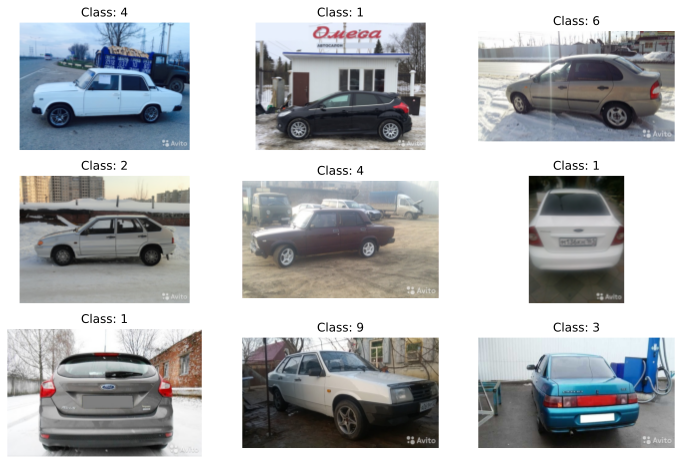

In [14]:
print('Пример картинок')
plt.figure(figsize=(12,8))

random_image = train_df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_PATH+f'train/{random_image_cat[index]}/{path}')
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

Картинки представлены разного размера

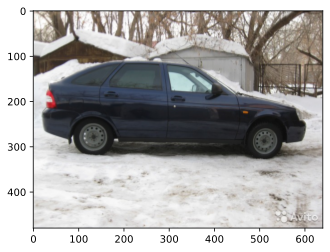

(640, 480)

In [15]:
#Посмотрим на примеры картинок и их размеры, чтобы понимать, как их лучше обрабатывать и сжимать.
image = PIL.Image.open(DATA_PATH+f'train/0/100380.jpg')
imgplot = plt.imshow(image)
plt.show()
image.size

In [16]:
#delete df no longer needed
del train_df
#collect residual garbage
gc.collect()

22731

# Аугментация данных

In [17]:
from ImageDataAugmentor.image_data_augmentor import *
import albumentations as A

In [18]:
AUGMENTATIONS = A.Compose([
    A.GaussianBlur(p=0.05),
    A.RandomBrightness(limit=0.2, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.0625, 
                       scale_limit=0.01, 
                       interpolation=1, 
                       border_mode=4, 
                       rotate_limit=20, 
                       p=.75),
    A.OneOf([
        A.CenterCrop(height=224, width=200),
        A.CenterCrop(height=200, width=224)],
        p=0.5),
    A.OneOf([
        A.RandomBrightnessContrast(brightness_limit=0.3, 
                                                contrast_limit=0.3),
        A.RandomBrightnessContrast(brightness_limit=0.1, 
                                                contrast_limit=0.1)],
        p=0.5),
    A.HorizontalFlip(p=0.5),
    A.HueSaturationValue(p=0.5),
    A.RGBShift(p=0.5),
    A.FancyPCA(alpha=0.1, 
               always_apply=False, 
               p=0.5),
    A.Resize(IMG_SIZE, IMG_SIZE)
])

/home/greg/anaconda3/envs/tf/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:1613: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


# Генерация данных

In [20]:
train_gen = ImageDataAugmentor(rescale=1./255,
                        augment=AUGMENTATIONS, 
                        seed=RANDOM_SEED,
                        validation_split=VAL_SPLIT
                       )

train_datagen = train_gen.flow_from_directory(DATA_PATH+'train', 
                                            class_mode='categorical', 
                                            batch_size=BATCH_SIZE, 
                                            target_size=(IMG_SIZE, IMG_SIZE),
                                            shuffle=True,
                                            subset='training'
                                           )
test_datagen = train_gen.flow_from_directory(DATA_PATH+'train', 
                                             class_mode='categorical', 
                                             batch_size=BATCH_SIZE, 
                                             target_size=(IMG_SIZE, IMG_SIZE),
                                             shuffle=True,
                                             subset='validation'
                                            )

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.


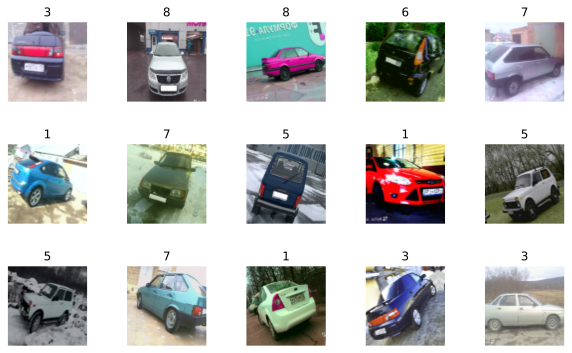

In [21]:
train_datagen.show_data(rows=3, cols=5)

# Модель

Download pre-trained model

In [22]:
# Загрузка модели efficientnet
# !pip install -q efficientnet

In [23]:
#from tensorflow.keras.applications.xception import Xception
#from tensorflow.keras.applications.inception_v3 import InceptionV3
import efficientnet.keras as efn 

In [24]:
# Pre-trained model

#base_model = Xception(weights='imagenet', 
#                      include_top=False, 
#                      input_shape = input_shape)

#base_model = InceptionV3(weights='imagenet', 
#                         include_top=False, 
#                         input_shape = input_shape)

base_model = efn.EfficientNetB5(weights='imagenet', 
                                include_top=False, 
                                input_shape = input_shape)

115515256/115515256 [==============================] - 11s 0us/step


In [25]:
base_model.summary()

Model: "efficientnet-b5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 48  1296        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn (BatchNormalization)   (None, 112, 112, 48  192         ['stem_conv[0][0]']              
                                )                                                   

                                                                                                  
 block1c_se_squeeze (GlobalAver  (None, 24)          0           ['block1c_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block1c_se_reshape (Reshape)   (None, 1, 1, 24)     0           ['block1c_se_squeeze[0][0]']     
                                                                                                  
 block1c_se_reduce (Conv2D)     (None, 1, 1, 6)      150         ['block1c_se_reshape[0][0]']     
                                                                                                  
 block1c_se_expand (Conv2D)     (None, 1, 1, 24)     168         ['block1c_se_reduce[0][0]']      
                                                                                                  
 block1c_s

                                                                                                  
 block2b_se_expand (Conv2D)     (None, 1, 1, 240)    2640        ['block2b_se_reduce[0][0]']      
                                                                                                  
 block2b_se_excite (Multiply)   (None, 56, 56, 240)  0           ['block2b_activation[0][0]',     
                                                                  'block2b_se_expand[0][0]']      
                                                                                                  
 block2b_project_conv (Conv2D)  (None, 56, 56, 40)   9600        ['block2b_se_excite[0][0]']      
                                                                                                  
 block2b_project_bn (BatchNorma  (None, 56, 56, 40)  160         ['block2b_project_conv[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 block2d_project_conv (Conv2D)  (None, 56, 56, 40)   9600        ['block2d_se_excite[0][0]']      
                                                                                                  
 block2d_project_bn (BatchNorma  (None, 56, 56, 40)  160         ['block2d_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block2d_drop (FixedDropout)    (None, 56, 56, 40)   0           ['block2d_project_bn[0][0]']     
                                                                                                  
 block2d_add (Add)              (None, 56, 56, 40)   0           ['block2d_drop[0][0]',           
                                                                  'block2c_add[0][0]']            
          

                                                                                                  
 block3b_expand_conv (Conv2D)   (None, 28, 28, 384)  24576       ['block3a_project_bn[0][0]']     
                                                                                                  
 block3b_expand_bn (BatchNormal  (None, 28, 28, 384)  1536       ['block3b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block3b_expand_activation (Act  (None, 28, 28, 384)  0          ['block3b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block3b_dwconv (DepthwiseConv2  (None, 28, 28, 384)  9600       ['block3b_expand_activation[0][0]
 D)       

                                                                                                  
 block3d_expand_activation (Act  (None, 28, 28, 384)  0          ['block3d_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block3d_dwconv (DepthwiseConv2  (None, 28, 28, 384)  9600       ['block3d_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block3d_bn (BatchNormalization  (None, 28, 28, 384)  1536       ['block3d_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block3d_a

 D)                                                              ']                               
                                                                                                  
 block4a_bn (BatchNormalization  (None, 14, 14, 384)  1536       ['block4a_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block4a_activation (Activation  (None, 14, 14, 384)  0          ['block4a_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4a_se_squeeze (GlobalAver  (None, 384)         0           ['block4a_activation[0][0]']     
 agePooling2D)                                                                                    
          

                                                                                                  
 block4c_se_reshape (Reshape)   (None, 1, 1, 768)    0           ['block4c_se_squeeze[0][0]']     
                                                                                                  
 block4c_se_reduce (Conv2D)     (None, 1, 1, 32)     24608       ['block4c_se_reshape[0][0]']     
                                                                                                  
 block4c_se_expand (Conv2D)     (None, 1, 1, 768)    25344       ['block4c_se_reduce[0][0]']      
                                                                                                  
 block4c_se_excite (Multiply)   (None, 14, 14, 768)  0           ['block4c_activation[0][0]',     
                                                                  'block4c_se_expand[0][0]']      
                                                                                                  
 block4c_p

 block4e_se_expand (Conv2D)     (None, 1, 1, 768)    25344       ['block4e_se_reduce[0][0]']      
                                                                                                  
 block4e_se_excite (Multiply)   (None, 14, 14, 768)  0           ['block4e_activation[0][0]',     
                                                                  'block4e_se_expand[0][0]']      
                                                                                                  
 block4e_project_conv (Conv2D)  (None, 14, 14, 128)  98304       ['block4e_se_excite[0][0]']      
                                                                                                  
 block4e_project_bn (BatchNorma  (None, 14, 14, 128)  512        ['block4e_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4e_d

 block4g_project_conv (Conv2D)  (None, 14, 14, 128)  98304       ['block4g_se_excite[0][0]']      
                                                                                                  
 block4g_project_bn (BatchNorma  (None, 14, 14, 128)  512        ['block4g_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4g_drop (FixedDropout)    (None, 14, 14, 128)  0           ['block4g_project_bn[0][0]']     
                                                                                                  
 block4g_add (Add)              (None, 14, 14, 128)  0           ['block4g_drop[0][0]',           
                                                                  'block4f_add[0][0]']            
                                                                                                  
 block5a_e

                                                                                                  
 block5c_expand_conv (Conv2D)   (None, 14, 14, 1056  185856      ['block5b_add[0][0]']            
                                )                                                                 
                                                                                                  
 block5c_expand_bn (BatchNormal  (None, 14, 14, 1056  4224       ['block5c_expand_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 block5c_expand_activation (Act  (None, 14, 14, 1056  0          ['block5c_expand_bn[0][0]']      
 ivation)                       )                                                                 
                                                                                                  
 block5c_d

                                                                                                  
 block5e_expand_bn (BatchNormal  (None, 14, 14, 1056  4224       ['block5e_expand_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 block5e_expand_activation (Act  (None, 14, 14, 1056  0          ['block5e_expand_bn[0][0]']      
 ivation)                       )                                                                 
                                                                                                  
 block5e_dwconv (DepthwiseConv2  (None, 14, 14, 1056  26400      ['block5e_expand_activation[0][0]
 D)                             )                                ']                               
                                                                                                  
 block5e_b

                                                                                                  
 block5g_expand_activation (Act  (None, 14, 14, 1056  0          ['block5g_expand_bn[0][0]']      
 ivation)                       )                                                                 
                                                                                                  
 block5g_dwconv (DepthwiseConv2  (None, 14, 14, 1056  26400      ['block5g_expand_activation[0][0]
 D)                             )                                ']                               
                                                                                                  
 block5g_bn (BatchNormalization  (None, 14, 14, 1056  4224       ['block5g_dwconv[0][0]']         
 )                              )                                                                 
                                                                                                  
 block5g_a

                                                                                                  
 block6b_activation (Activation  (None, 7, 7, 1824)  0           ['block6b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block6b_se_squeeze (GlobalAver  (None, 1824)        0           ['block6b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6b_se_reshape (Reshape)   (None, 1, 1, 1824)   0           ['block6b_se_squeeze[0][0]']     
                                                                                                  
 block6b_se_reduce (Conv2D)     (None, 1, 1, 76)     138700      ['block6b_se_reshape[0][0]']     
          

 agePooling2D)                                                                                    
                                                                                                  
 block6d_se_reshape (Reshape)   (None, 1, 1, 1824)   0           ['block6d_se_squeeze[0][0]']     
                                                                                                  
 block6d_se_reduce (Conv2D)     (None, 1, 1, 76)     138700      ['block6d_se_reshape[0][0]']     
                                                                                                  
 block6d_se_expand (Conv2D)     (None, 1, 1, 1824)   140448      ['block6d_se_reduce[0][0]']      
                                                                                                  
 block6d_se_excite (Multiply)   (None, 7, 7, 1824)   0           ['block6d_activation[0][0]',     
                                                                  'block6d_se_expand[0][0]']      
          

                                                                                                  
 block6f_se_expand (Conv2D)     (None, 1, 1, 1824)   140448      ['block6f_se_reduce[0][0]']      
                                                                                                  
 block6f_se_excite (Multiply)   (None, 7, 7, 1824)   0           ['block6f_activation[0][0]',     
                                                                  'block6f_se_expand[0][0]']      
                                                                                                  
 block6f_project_conv (Conv2D)  (None, 7, 7, 304)    554496      ['block6f_se_excite[0][0]']      
                                                                                                  
 block6f_project_bn (BatchNorma  (None, 7, 7, 304)   1216        ['block6f_project_conv[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 block6h_project_conv (Conv2D)  (None, 7, 7, 304)    554496      ['block6h_se_excite[0][0]']      
                                                                                                  
 block6h_project_bn (BatchNorma  (None, 7, 7, 304)   1216        ['block6h_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6h_drop (FixedDropout)    (None, 7, 7, 304)    0           ['block6h_project_bn[0][0]']     
                                                                                                  
 block6h_add (Add)              (None, 7, 7, 304)    0           ['block6h_drop[0][0]',           
                                                                  'block6g_add[0][0]']            
          

                                                                                                  
 block7b_expand_conv (Conv2D)   (None, 7, 7, 3072)   1572864     ['block7a_project_bn[0][0]']     
                                                                                                  
 block7b_expand_bn (BatchNormal  (None, 7, 7, 3072)  12288       ['block7b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block7b_expand_activation (Act  (None, 7, 7, 3072)  0           ['block7b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block7b_dwconv (DepthwiseConv2  (None, 7, 7, 3072)  27648       ['block7b_expand_activation[0][0]
 D)       

 top_activation (Activation)    (None, 7, 7, 2048)   0           ['top_bn[0][0]']                 
                                                                                                  
Total params: 28,513,520
Trainable params: 28,340,784
Non-trainable params: 172,736
__________________________________________________________________________________________________


In [26]:
# freeze the pre-trained model weights, train only the top layers
base_model.trainable = False

In [27]:
model=Model.Sequential()
model.add(base_model)
model.add(Layer.GlobalAveragePooling2D())
model.add(Layer.Dense(256, 
                      activation='relu', 
                      bias_regularizer=l2(1e-4),
                      activity_regularizer=l2(1e-5)))
model.add(Layer.BatchNormalization())
model.add(Layer.Dropout(0.25))
model.add(Layer.Dense(CLASS_NUM, activation='softmax'))

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b5 (Functional  (None, 7, 7, 2048)       28513520  
 )                                                               
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                        

In [29]:
# Check the trainable status of the individual layers
for layer in model.layers:
    print(layer, layer.trainable)

<keras.engine.functional.Functional object at 0x7f89644041c0> False
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7f89641e1610> True
<keras.layers.core.dense.Dense object at 0x7f89641039d0> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f896417a220> True
<keras.layers.regularization.dropout.Dropout object at 0x7f896417a790> True
<keras.layers.core.dense.Dense object at 0x7f896416c400> True


# Fit

In [30]:
model.compile(loss="categorical_crossentropy", 
              optimizer=optimizers.Adam(learning_rate=LR), 
              metrics=["accuracy"])

In [31]:
# Добавим ModelCheckpoint. 
# Эта функция позволяет сохранять прогресс обучения модели, 
# чтобы в нужный момент можно было его подгрузить и дообучить модель.
checkpoint = ModelCheckpoint(WORK_PATH+'best_model.hdf5', 
                             monitor = ['val_accuracy'], 
                             verbose = 1,
                             mode = 'max')
earlystop = EarlyStopping(monitor = 'val_accuracy',
                          patience = 4,
                          restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.25,
                              patience=2,
                              min_lr=0.0000001,
                              verbose=1,
                              mode='auto')
callbacks_list = [checkpoint, earlystop, reduce_lr]

In [33]:
history = model.fit(
        train_datagen,
        steps_per_epoch = train_datagen.samples//train_datagen.batch_size,
        validation_data = test_datagen, 
        validation_steps = test_datagen.samples//test_datagen.batch_size,
        epochs = EPOCHS,
        callbacks = callbacks_list
)

Epoch 1/8


2022-07-31 15:14:09.787927: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-07-31 15:14:09.788379: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


1654/1654 [==============================] - ETA: 0s - loss: 1.4471 - accuracy: 0.4971
Epoch 1: saving model to ./work/best_model.hdf5
1654/1654 [==============================] - 138s 78ms/step - loss: 1.4471 - accuracy: 0.4971 - val_loss: 1.0934 - val_accuracy: 0.6276 - lr: 0.0010
Epoch 2/8
1654/1654 [==============================] - ETA: 0s - loss: 1.1722 - accuracy: 0.5828
Epoch 2: saving model to ./work/best_model.hdf5
1654/1654 [==============================] - 128s 78ms/step - loss: 1.1722 - accuracy: 0.5828 - val_loss: 0.9871 - val_accuracy: 0.6611 - lr: 0.0010
Epoch 3/8
1654/1654 [==============================] - ETA: 0s - loss: 1.1193 - accuracy: 0.6093
Epoch 3: saving model to ./work/best_model.hdf5
1654/1654 [==============================] - 127s 77ms/step - loss: 1.1193 - accuracy: 0.6093 - val_loss: 0.9124 - val_accuracy: 0.6692 - lr: 0.0010
Epoch 4/8
1654/1654 [==============================] - ETA: 0s - loss: 1.0723 - accuracy: 0.6276
Epoch 4: saving model to ./work

In [34]:
model.save(WORK_PATH+'model_last.hdf5') 
model.load_weights(WORK_PATH+'best_model.hdf5')

In [36]:
scores = model.evaluate(test_datagen, steps=len(test_datagen), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

292/292 [==============================] - 20s 68ms/step - loss: 0.8298 - accuracy: 0.7222
Accuracy: 72.22%


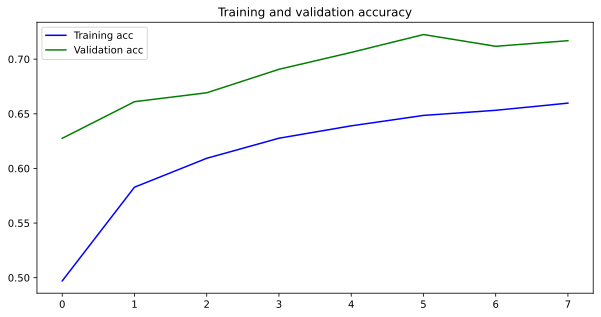

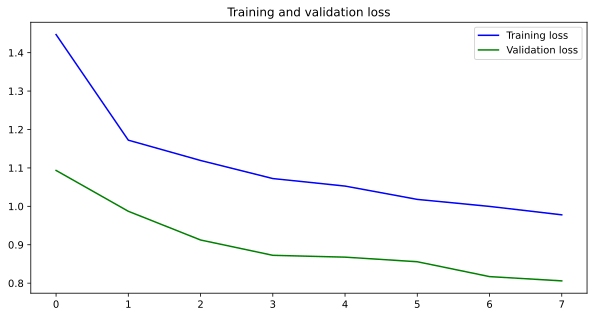

In [37]:
def plot_history(history):
    plt.figure(figsize=(10,5))
    #plt.style.use('dark_background')
    acc = history.history['accuracy'] 
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'g', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    #plt.figure()
    plt.figure(figsize=(10,5))
    #plt.style.use('dark_background')
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

plot_history(history)

## Step 2
### defrost a half of the pre-trained model weights

In [38]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = len(base_model.layers)//2

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [39]:
LR=0.0001
model.compile(loss="categorical_crossentropy", 
              optimizer=optimizers.Adam(learning_rate=LR), 
              metrics=["accuracy"])

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b5 (Functional  (None, 7, 7, 2048)       28513520  
 )                                                               
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                        

In [41]:
history = model.fit(
        train_datagen,
        steps_per_epoch = train_datagen.samples//train_datagen.batch_size,
        validation_data = test_datagen, 
        validation_steps = test_datagen.samples//test_datagen.batch_size,
        epochs = EPOCHS,
        callbacks = callbacks_list
)

Epoch 1/8
1654/1654 [==============================] - ETA: 0s - loss: 1.0182 - accuracy: 0.6709
Epoch 1: saving model to ./work/best_model.hdf5
1654/1654 [==============================] - 155s 88ms/step - loss: 1.0182 - accuracy: 0.6709 - val_loss: 0.4070 - val_accuracy: 0.8552 - lr: 1.0000e-04
Epoch 2/8
1654/1654 [==============================] - ETA: 0s - loss: 0.5295 - accuracy: 0.8233
Epoch 2: saving model to ./work/best_model.hdf5
1654/1654 [==============================] - 142s 86ms/step - loss: 0.5295 - accuracy: 0.8233 - val_loss: 0.3150 - val_accuracy: 0.8914 - lr: 1.0000e-04
Epoch 3/8
1654/1654 [==============================] - ETA: 0s - loss: 0.4081 - accuracy: 0.8662
Epoch 3: saving model to ./work/best_model.hdf5
1654/1654 [==============================] - 142s 86ms/step - loss: 0.4081 - accuracy: 0.8662 - val_loss: 0.2529 - val_accuracy: 0.9164 - lr: 1.0000e-04
Epoch 4/8
1654/1654 [==============================] - ETA: 0s - loss: 0.3226 - accuracy: 0.8951
Epoch 4: 

In [42]:
model.save(WORK_PATH+'model_last.hdf5') 
model.load_weights(WORK_PATH+'best_model.hdf5')

In [43]:
scores = model.evaluate(test_datagen, steps=len(test_datagen), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

292/292 [==============================] - 18s 62ms/step - loss: 0.2381 - accuracy: 0.9249
Accuracy: 92.49%


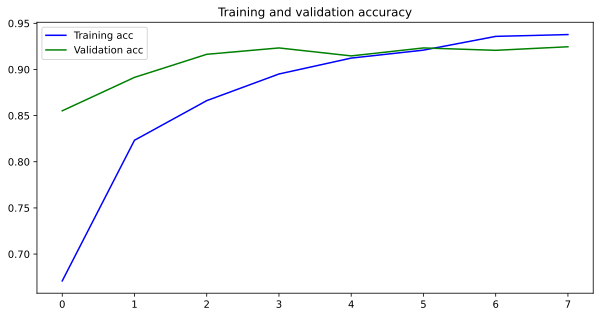

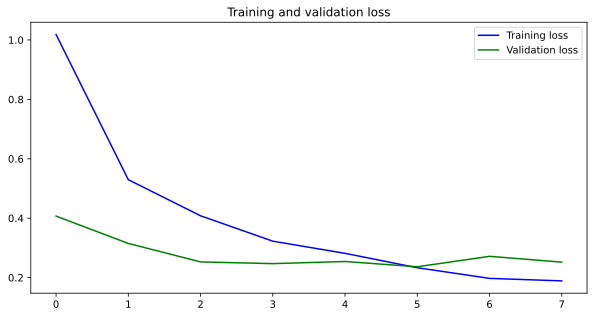

In [44]:
plot_history(history)

## Step 3
### defrost three quarters of the pre-trained model weights

In [45]:
base_model.trainable = True
# Fine-tune from this layer onwards
fine_tune_at = len(base_model.layers)//4

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [46]:
LR=0.00001
model.compile(loss="categorical_crossentropy", 
              optimizer=optimizers.Adam(learning_rate=LR), 
              metrics=["accuracy"])

In [47]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b5 (Functional  (None, 7, 7, 2048)       28513520  
 )                                                               
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                        

In [48]:
history = model.fit(
        train_datagen,
        steps_per_epoch = train_datagen.samples//train_datagen.batch_size,
        validation_data = test_datagen, 
        validation_steps = test_datagen.samples//test_datagen.batch_size,
        epochs = EPOCHS,
        callbacks = callbacks_list
)

Epoch 1/8
1654/1654 [==============================] - ETA: 0s - loss: 0.1465 - accuracy: 0.9522
Epoch 1: saving model to ./work/best_model.hdf5
1654/1654 [==============================] - 163s 93ms/step - loss: 0.1465 - accuracy: 0.9522 - val_loss: 0.2200 - val_accuracy: 0.9349 - lr: 1.0000e-05
Epoch 2/8
1654/1654 [==============================] - ETA: 0s - loss: 0.1222 - accuracy: 0.9618
Epoch 2: saving model to ./work/best_model.hdf5
1654/1654 [==============================] - 149s 90ms/step - loss: 0.1222 - accuracy: 0.9618 - val_loss: 0.1957 - val_accuracy: 0.9393 - lr: 1.0000e-05
Epoch 3/8
1654/1654 [==============================] - ETA: 0s - loss: 0.1059 - accuracy: 0.9652
Epoch 3: saving model to ./work/best_model.hdf5
1654/1654 [==============================] - 150s 91ms/step - loss: 0.1059 - accuracy: 0.9652 - val_loss: 0.1879 - val_accuracy: 0.9423 - lr: 1.0000e-05
Epoch 4/8
1654/1654 [==============================] - ETA: 0s - loss: 0.1074 - accuracy: 0.9674
Epoch 4: 

In [49]:
model.save(WORK_PATH+'model_last.hdf5') 
model.load_weights(WORK_PATH+'best_model.hdf5')

In [50]:
scores = model.evaluate(test_datagen, steps=len(test_datagen), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

292/292 [==============================] - 19s 66ms/step - loss: 0.2099 - accuracy: 0.9480
Accuracy: 94.80%


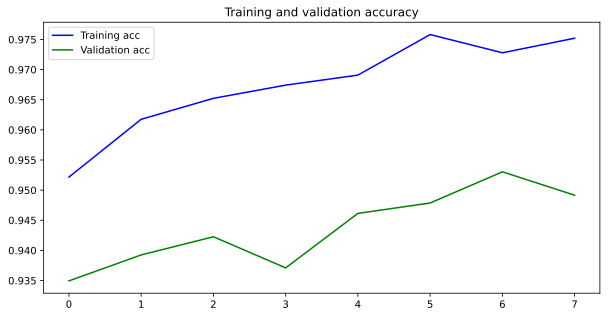

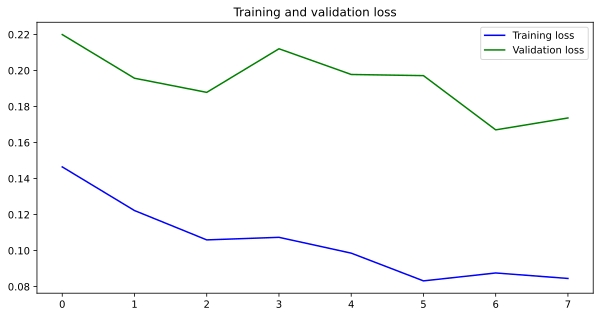

In [51]:
plot_history(history)

## Step 4
### complete weights defrosting

In [52]:
base_model.trainable = True
LR=0.000001
#EPOCHS = 10

model.compile(loss="categorical_crossentropy", 
              optimizer=optimizers.Adam(learning_rate=LR), 
              metrics=["accuracy"])

In [53]:
history = model.fit(
        train_datagen,
        steps_per_epoch = train_datagen.samples//train_datagen.batch_size,
        validation_data = test_datagen, 
        validation_steps = test_datagen.samples//test_datagen.batch_size,
        epochs = EPOCHS,
        callbacks = callbacks_list
)

Epoch 1/8
1654/1654 [==============================] - ETA: 0s - loss: 0.0938 - accuracy: 0.9713
Epoch 1: saving model to ./work/best_model.hdf5
1654/1654 [==============================] - 279s 162ms/step - loss: 0.0938 - accuracy: 0.9713 - val_loss: 0.1924 - val_accuracy: 0.9418 - lr: 1.0000e-06
Epoch 2/8
1654/1654 [==============================] - ETA: 0s - loss: 0.0899 - accuracy: 0.9720
Epoch 2: saving model to ./work/best_model.hdf5
1654/1654 [==============================] - 266s 161ms/step - loss: 0.0899 - accuracy: 0.9720 - val_loss: 0.1583 - val_accuracy: 0.9500 - lr: 1.0000e-06
Epoch 3/8
1654/1654 [==============================] - ETA: 0s - loss: 0.0883 - accuracy: 0.9716
Epoch 3: saving model to ./work/best_model.hdf5
1654/1654 [==============================] - 271s 164ms/step - loss: 0.0883 - accuracy: 0.9716 - val_loss: 0.1880 - val_accuracy: 0.9470 - lr: 1.0000e-06
Epoch 4/8
1654/1654 [==============================] - ETA: 0s - loss: 0.0890 - accuracy: 0.9736
Epoch 

In [54]:
model.save(WORK_PATH+'model_last.hdf5') 
model.load_weights(WORK_PATH+'best_model.hdf5')

In [55]:
scores = model.evaluate(test_datagen, steps=len(test_datagen), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

292/292 [==============================] - 19s 64ms/step - loss: 0.1781 - accuracy: 0.9472
Accuracy: 94.72%


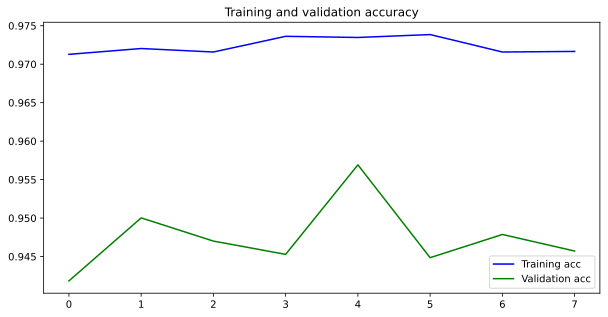

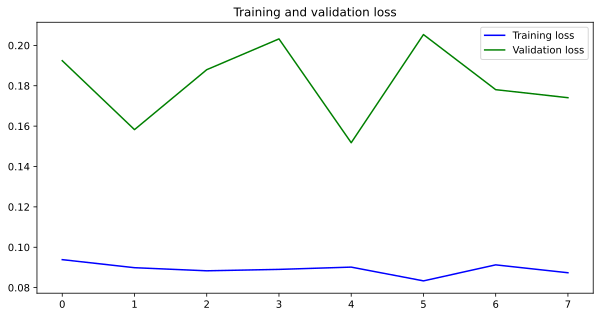

In [56]:
plot_history(history)

# Prediction after fine-tuning

In [57]:
test_gen = ImageDataAugmentor(rescale=1./255)
test_sub_generator = test_gen.flow_from_dataframe(dataframe=sample_submission,
                                            directory=DATA_PATH+'test/',
                                            x_col="Id",
                                            y_col=None,
                                            shuffle=False,
                                            class_mode=None,
                                            target_size=(IMG_SIZE, IMG_SIZE),
                                            batch_size=BATCH_SIZE)

Found 6675 validated image filenames.


In [58]:
test_sub_generator.reset()
predictions = model.predict(test_sub_generator, 
                            steps=len(test_sub_generator), 
                            verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_datagen.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

835/835 [==============================] - 22s 25ms/step


In [59]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, 
                          columns=['Id', 'Category'])

submission.to_csv(WORK_PATH+'submission.csv', index=False)

## Step 5. IMG_SIZE rise

In [60]:
EPOCHS               = 6
BATCH_SIZE           = 2 
LR                   = 1e-5

IMG_SIZE             = 512
IMG_CHANNELS         = 3
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

In [61]:
AUGMENTATIONS = A.Compose([
    #A.RandomBrightness(limit=0.2, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.0625, 
                       scale_limit=0.01, 
                       interpolation=1, 
                       border_mode=4, 
                       rotate_limit=20, 
                       p=.75),
    A.HorizontalFlip(p=0.5),
    #A.HueSaturationValue(p=0.5)
])

In [62]:
train_gen = ImageDataAugmentor(rescale=1./255,
                        augment=AUGMENTATIONS, 
                        seed=RANDOM_SEED,
                        validation_split=VAL_SPLIT
                       )

train_datagen = train_gen.flow_from_directory(DATA_PATH+'train/', 
                                            class_mode='categorical', 
                                            batch_size=BATCH_SIZE, 
                                            target_size=(IMG_SIZE, IMG_SIZE),
                                            shuffle=True,
                                            subset='training'
                                           )
test_datagen = train_gen.flow_from_directory(DATA_PATH+'train/', 
                                             class_mode='categorical', 
                                             batch_size=BATCH_SIZE, 
                                             target_size=(IMG_SIZE, IMG_SIZE),
                                             shuffle=True,
                                             subset='validation'
                                            )

test_gen = ImageDataAugmentor(rescale=1./255)
test_sub_generator = test_gen.flow_from_dataframe(dataframe=sample_submission,
                                            directory=DATA_PATH+'test/',
                                            x_col="Id",
                                            y_col=None,
                                            shuffle=False,
                                            class_mode=None,
                                            target_size=(IMG_SIZE, IMG_SIZE),
                                            batch_size=BATCH_SIZE)

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.


In [63]:
# Re-create the net with the new size of the input data

#base_model = Xception(weights='imagenet', 
#                            include_top=False, 
#                            input_shape = input_shape)

#base_model = InceptionV3(weights='imagenet', 
#                            include_top=False, 
#                            input_shape = input_shape)


base_model = efn.EfficientNetB5(weights='imagenet', 
                                include_top=False, 
                                input_shape = input_shape)

In [64]:
base_model.trainable = True

In [65]:
model.compile(loss="categorical_crossentropy", 
              optimizer=optimizers.Adam(learning_rate=LR), 
              metrics=["accuracy"])

model.load_weights(WORK_PATH+'best_model.hdf5')

In [66]:
history = model.fit(
        train_datagen,
        steps_per_epoch = train_datagen.samples//train_datagen.batch_size,
        validation_data = test_datagen, 
        validation_steps = test_datagen.samples//test_datagen.batch_size,
        epochs = EPOCHS,
        callbacks = callbacks_list
)

Epoch 1/6
6616/6616 [==============================] - ETA: 0s - loss: 0.9361 - accuracy: 0.7799
Epoch 1: saving model to ./work/best_model.hdf5
6616/6616 [==============================] - 1365s 205ms/step - loss: 0.9361 - accuracy: 0.7799 - val_loss: 0.1530 - val_accuracy: 0.9652 - lr: 1.0000e-05
Epoch 2/6
6616/6616 [==============================] - ETA: 0s - loss: 0.7466 - accuracy: 0.8381
Epoch 2: saving model to ./work/best_model.hdf5
6616/6616 [==============================] - 1400s 212ms/step - loss: 0.7466 - accuracy: 0.8381 - val_loss: 0.1375 - val_accuracy: 0.9699 - lr: 1.0000e-05
Epoch 3/6
6616/6616 [==============================] - ETA: 0s - loss: 0.6030 - accuracy: 0.8625
Epoch 3: saving model to ./work/best_model.hdf5
6616/6616 [==============================] - 1445s 218ms/step - loss: 0.6030 - accuracy: 0.8625 - val_loss: 0.1597 - val_accuracy: 0.9601 - lr: 1.0000e-05
Epoch 4/6
6616/6616 [==============================] - ETA: 0s - loss: 0.5553 - accuracy: 0.8747
Epo

In [ ]:
#!find /kaggle/working -name "*.hdf5" -type f -delete

In [67]:
scores = model.evaluate(test_datagen, steps=len(test_datagen), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

1165/1165 [==============================] - 40s 35ms/step - loss: 0.1757 - accuracy: 0.9695
Accuracy: 96.95%


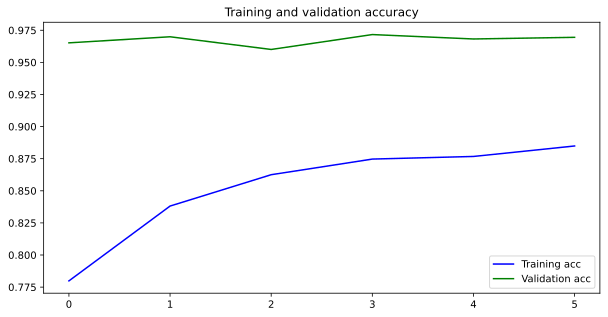

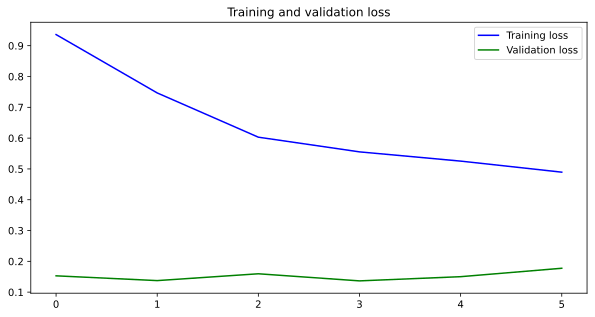

In [68]:
plot_history(history)

# Prediction after IMG_SIZE rise

In [69]:
test_sub_generator.reset()
predictions = model.predict(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_datagen.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

3338/3338 [==============================] - 106s 31ms/step


In [70]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])

In [71]:
submission.to_csv(WORK_PATH+'submission_IMG_SIZE.csv', index=False)

# Test Time Augmentation (TTA)

Augment test images.         
Make several predictions of one picture in a different way.         
=> The final prediction is obtained by taking the average of several predictions.

In [72]:
model.load_weights(WORK_PATH+'best_model.hdf5')

In [73]:
AUGMENTATIONS = A.Compose([
    A.GaussianBlur(p=0.05),
    A.RandomBrightness(limit=0.2, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.0625, 
                       scale_limit=0.01, 
                       interpolation=1, 
                       border_mode=4, 
                       rotate_limit=20, 
                       p=.75),
    A.OneOf([
        A.RandomBrightnessContrast(brightness_limit=0.3, 
                                                contrast_limit=0.3),
        A.RandomBrightnessContrast(brightness_limit=0.1, 
                                                contrast_limit=0.1)],
        p=0.5),
    A.HorizontalFlip(p=0.5),
    A.HueSaturationValue(p=0.5),
    A.RGBShift(p=0.5),
    A.FancyPCA(alpha=0.1, 
               always_apply=False, 
               p=0.5),
    A.Resize(IMG_SIZE, IMG_SIZE)
])

/home/greg/anaconda3/envs/tf/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:1613: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


In [74]:
test_gen = ImageDataAugmentor(rescale=1./255,
                        augment=AUGMENTATIONS, 
                        seed=RANDOM_SEED,
                        validation_split=VAL_SPLIT
                       )

test_sub_generator = test_gen.flow_from_dataframe(dataframe=sample_submission,
                                      directory=DATA_PATH+'test',
                                      x_col="Id",
                                      y_col=None,
                                      target_size=(IMG_SIZE, IMG_SIZE),
                                      batch_size=BATCH_SIZE,
                                      class_mode=None,
                                      shuffle=False)

Found 6675 validated image filenames.


In [76]:
tta_steps = 10
predictions = []

for i in range(tta_steps):
    preds = model.predict(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
    predictions.append(preds)

pred = np.mean(predictions, axis=0)

3338/3338 [==============================] - 165s 49ms/step


In [77]:
predictions = np.argmax(pred, axis=-1) #multiple categories
label_map = (train_datagen.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, 
                          columns=['Id', 'Category'])

In [78]:
scores = model.evaluate(test_datagen, steps=len(test_datagen), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

1165/1165 [==============================] - 37s 32ms/step - loss: 0.1679 - accuracy: 0.9704
Accuracy: 97.04%


In [79]:
submission.to_csv(WORK_PATH+'submission_TTA.csv', index=False)

In [80]:
# Удалить папку с моделями
# Clean PATH
import shutil
shutil.rmtree(WORK_PATH)

# Model efficiency summary          
         
- **Fine-tuning Xception**         
---
- **Fine-tuning InceptionV3**       
---
- **Fine-tuning EfficientNetB5**       
- 0% weights defrosting accuracy 72.22%
- 50% weights defrosting accuracy 92.49%
- 75% weights defrosting accuracy 94.80%
- 100% weights defrosting accuracy 94.72%
- image size rising accuracy 96.95%
- TTA accuracy **97.04%**

# Итоги             
                    
В проекте применены:     
- transfer learning и fine-tuning (обучение головы -> 50% разморозка весов предобученной модели -> 75% разморозка -> 100% разморозка)
- дополнительные функции callback в Keras        
- настройка LR    
- настройка параметров регуляризации полносвязного слоя нейронной сети
- применен способ заполнения пропусков c помощью ImageDataAugmentor с использованием библиотеки аугментации изображений albumentations
- подобраны переменные (размер картинки, батч, количество эпох)
- добавлена Batch Normalization в архитектуре “головы” модели
- SOTA архитектура сетей - Xception, InceptionV3, EfficientNetB5
- добавлена TTA (Test Time Augmentation)
                  
Ввиду ограничений на пользование ресурсами GPU и времязатратности самого просчета модели, не удалось протестировать следующие техники настройки модели:
- настройка optimizer
- настройка loss
- использование внешних датасетов для дообучения модели
               